In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

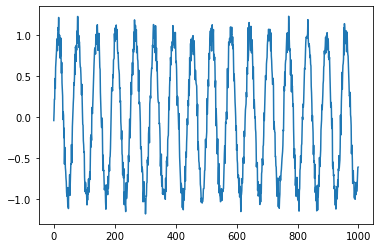

In [8]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# plot it
plt.plot(series)
plt.show()
#print(series)

In [24]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1,T)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


In [25]:
### try autoregressive linear model
model = nn.Linear(T,1)

In [26]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [48]:
X[:N//2].shape

(495, 10)

In [49]:
# Make inputs and targets
x_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
x_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

In [51]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 5 ==0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [52]:
train_losses, test_losses = full_gd(model, criterion, optimizer, x_train, y_train, x_test, y_test)

Epoch 5/200, Train Loss: 0.1205, Test Loss: 0.1184
Epoch 10/200, Train Loss: 0.0578, Test Loss: 0.0551
Epoch 15/200, Train Loss: 0.0649, Test Loss: 0.0542
Epoch 20/200, Train Loss: 0.0439, Test Loss: 0.0314
Epoch 25/200, Train Loss: 0.0222, Test Loss: 0.0180
Epoch 30/200, Train Loss: 0.0212, Test Loss: 0.0207
Epoch 35/200, Train Loss: 0.0194, Test Loss: 0.0197
Epoch 40/200, Train Loss: 0.0155, Test Loss: 0.0173
Epoch 45/200, Train Loss: 0.0163, Test Loss: 0.0177
Epoch 50/200, Train Loss: 0.0163, Test Loss: 0.0164
Epoch 55/200, Train Loss: 0.0149, Test Loss: 0.0155
Epoch 60/200, Train Loss: 0.0148, Test Loss: 0.0159
Epoch 65/200, Train Loss: 0.0148, Test Loss: 0.0155
Epoch 70/200, Train Loss: 0.0144, Test Loss: 0.0153
Epoch 75/200, Train Loss: 0.0144, Test Loss: 0.0153
Epoch 80/200, Train Loss: 0.0143, Test Loss: 0.0152
Epoch 85/200, Train Loss: 0.0142, Test Loss: 0.0151
Epoch 90/200, Train Loss: 0.0142, Test Loss: 0.0151
Epoch 95/200, Train Loss: 0.0141, Test Loss: 0.0150
Epoch 100/200

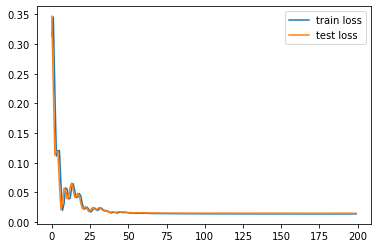

In [53]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [86]:
# "Wrong" forecast using true targets

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = x_test[i].view(1,-1)  # 10개씩 tensor가 input 됨
    p = model(input_)[0,0].item()  # 1 x 1 array -> scalar  (첫번째 tensor를 선택) --> 10개의 N에 대하여 1개 prediction
    i += 1
    
    # update the predictions list
    validation_predictions.append(p)
    #print(validation_predictions)

In [87]:
x_test[0].view(1,-1)[0,0]

tensor(-0.6585)

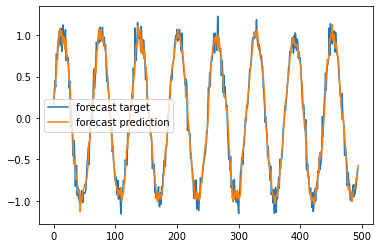

In [88]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label ='forecast prediction')
plt.legend()
plt.show()

In [90]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[N//2:].astype(np.float32))[0]
print(last_x)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, -1)
    p = model(input_)
    # [0,0] # 1 x 1 array -> scalar
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())     # 여기까지는 도입 부분을 전과 바꾼 것이지 실지로는 똑같다.
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))      # seq 함수와 같은 역할을 한다. 한칸 이동한 x 값에 p : prediction 값을 추가함
    #print(last_x)                               # last_x 는 계속 한칸씩 이동하며 10개 tensor를 유지한다.

tensor([-0.6585, -0.6508, -0.4745, -0.2753, -0.3778, -0.2916, -0.2477, -0.1848,
         0.2226,  0.0336])


In [91]:
x = torch.randn(2, 3)
torch.cat((x, x))

tensor([[ 1.7518,  0.3806,  0.7708],
        [ 1.5195, -0.3535, -1.4856],
        [ 1.7518,  0.3806,  0.7708],
        [ 1.5195, -0.3535, -1.4856]])

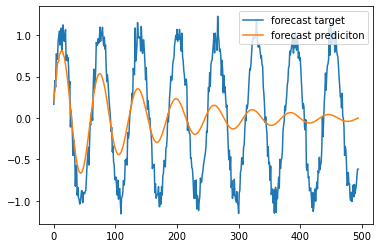

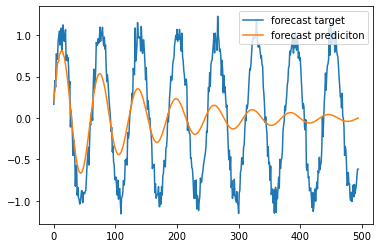

In [93]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediciton')
plt.legend()
plt.show(0)